# Object Oriented Programming in Python - Part 5: Libraries for Scientific Programming

## 10316 Materials design with machine learning and artificial intelligence



***

### Plan for today

Lecture:
* A look at the LennardJones class
* Python tip of the day: Container classes
* Important scientific libraries

Exercise:
* Finish up your Molecular Dynamics code
* Optional: Build an energy minimizer as a "Facade" to scipy's function minimization
* Optional: Play with ``matplotlib``, ``pandas`` or one of the other libraries.

In [ ]:
import numpy as np

## Building a Lennard-Jones potential

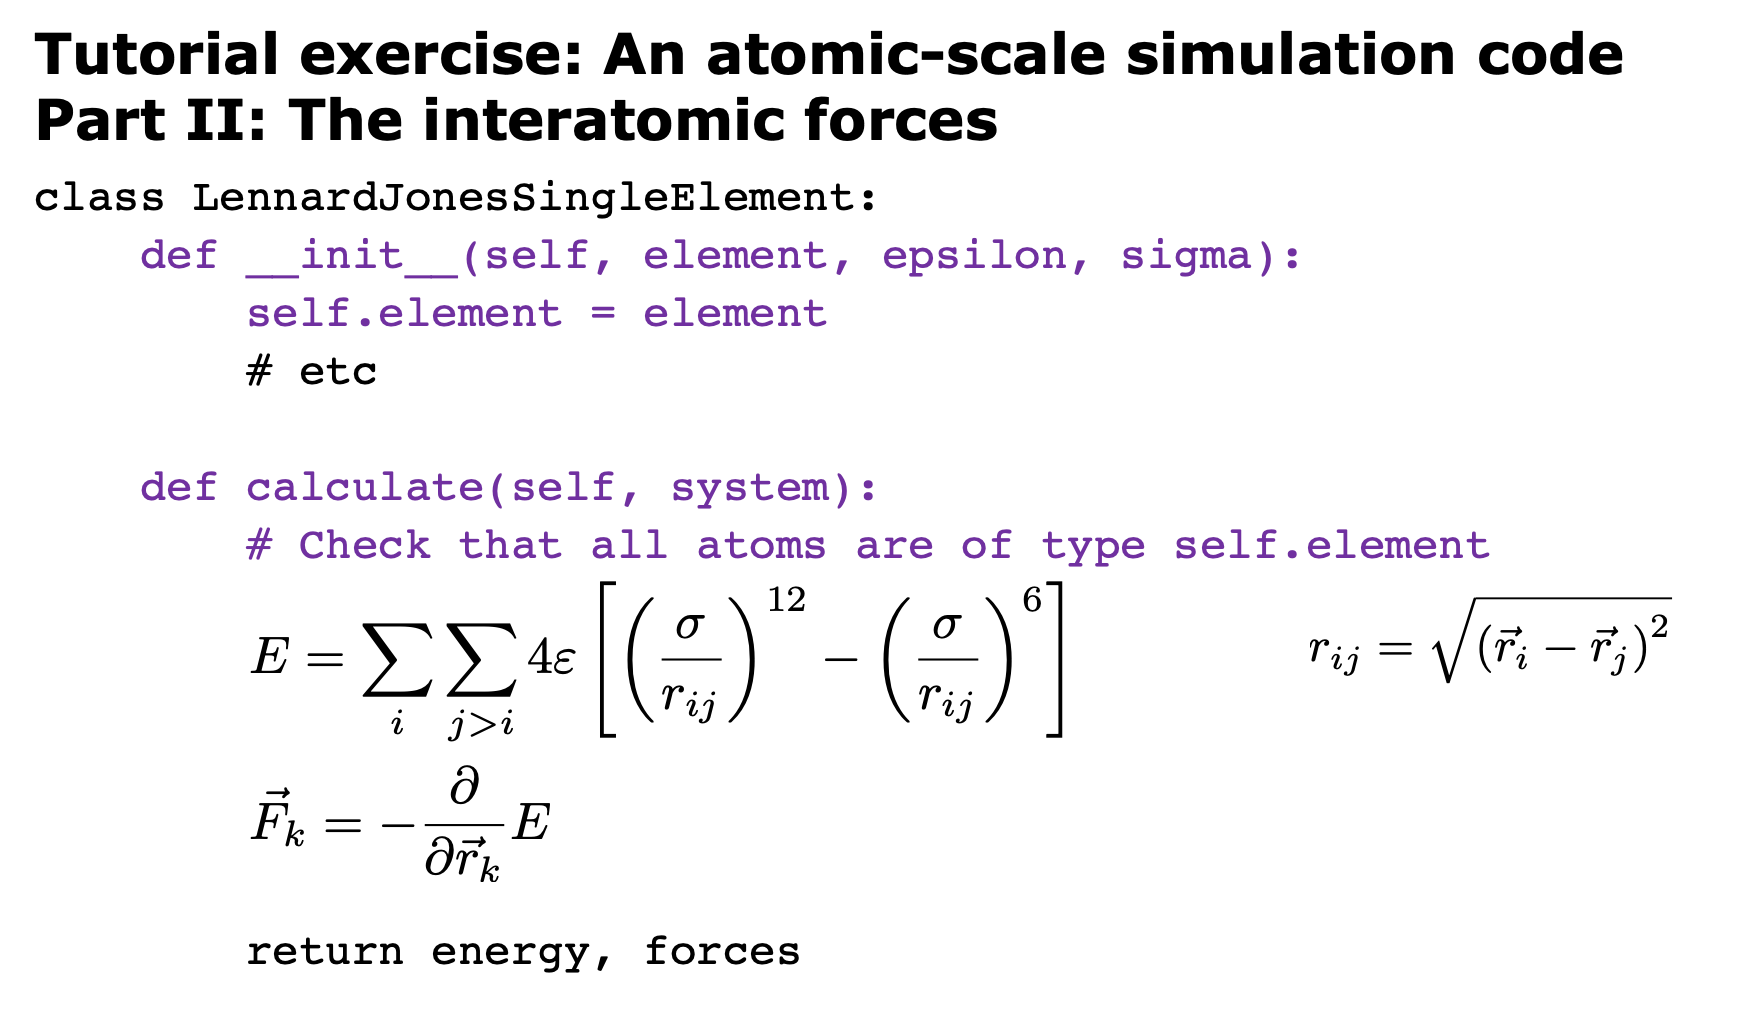

### First, identify the formula we want to implement.

As it caused some confusion that I used $r_{i,x}$ for the x-coordinate of atom $i$, but also $r_{ij}$ (wihtout a comma) for the distance between the two, I will rename the latter to $d_ij$.  

$$
E = \sum_i \sum_{j > i} U(d_{ij})
$$
where
$$
U(d_{ij}) = 4 \varepsilon \left[
      \left( {\sigma \over d_{ij} } \right)^{12} -
      \left( {\sigma \over d_{ij} } \right)^{6} \right]
$$
and
$$
d_{ij} = \sqrt{\left(\vec r_i - \vec r_j \right)^2}
$$

This is how we will implement it: A method doing the double sum, calculating $d_{ij}$ (by calling a method) and then calculating $U$ by calling another method.

Note that the energy is a scalar (a single number).  One could define an energy per atom, but that is not possible with all models.



In [ ]:
class LennardJones_NoForcesYet:
    """Lennard Jones potential for a single element."""
    def __init__(self, element, epsilon, sigma):
        """Create the potential.
        
        element: The symbol of the element that will be supported.
        
        epsilon and sigma: The LJ parameters
        """
        self.element = element
        self.sigma = sigma
        self.epsilon = epsilon
        
    def calculate(self, system):
        # Check that all atoms have the right element
        for a in system:
            if a.symbol != self.element:
                raise ValueError("Found element {} but only support {}".format(
                    a.symbol, self.element))
        # The calculation could be optimized by calculating energy and
        # forces in the same loop, but keep is simple to begin with...
        E = self.calculate_energy(system)
        F = self.calculate_forces(system)
        return E, F
    
    def calculate_energy(self, system):
        U = 0
        N = len(system)  # Number of atoms
        for i in range(N):
            for j in range(i+1, N):
                pos_i = system[i].position
                pos_j = system[j].position
                dij = self.calculate_d_ij(pos_i, pos_j)
                U += self.calculate_U(dij)
        return U
    
    def calculate_d_ij(self, pos_i, pos_j):
        d = pos_i - pos_j
        d_squared = d * d
        return np.sqrt(d_squared.sum())
    
    def calculate_U(self, dij):
        x = (self.sigma / dij)**6
        return 4 * self.epsilon * (x**2 - x)
    
    def calculate_forces(self, system):
        "Not implemented yet"
        return None

### Test it with a Hydrogen dimer.
Energy is zero when distance is $\sigma$.  Energy is minimal at $2^{1/6} \sigma$.  Energy is zero again at large distances.

In [ ]:
from atom import Atom
from molecule import Molecule

def dimer(distance):
    atom1 = Atom('H', 0, 0, 0)
    atom2 = Atom('H', distance, 0, 0)
    return Molecule([atom1, atom2])

epsilon = 4.4778900
sigma = 0.5523570
model = LennardJones('H', epsilon, sigma)

In [ ]:
dimer(sigma)

In [ ]:
model.calculate(dimer(sigma * 2))

### The forces

We use the chain rule, as I showed yesterday (see the pdf of my virtual whiteboard, Force.pdf).

Let the $\alpha$ component (x, y or z) of the force on atom $k$ be called $F_{k,\alpha}$.  The forces F will thus be an N by 3 array of forces on all the atoms.

$$
F_{k, \alpha} = - {dE \over dr_{k,\alpha}} = - \sum_i \sum_{j>i} {dU \over dr_{k,\alpha}}
$$
where
\begin{eqnarray}
{dU \over dr_{k,\alpha}} &=& {dU \over dd_{ij}} {dd_{ij} \over dr_{k,\alpha}}\\
{dU \over dd_{ij}} &=& 4 \epsilon {\left( -12 {\sigma^{12} \over d_{ij}^{13}} 
+ 6 {\sigma^{6} \over d_{ij}^{7}} 
 \right)}
\end{eqnarray}
and
\begin{eqnarray}
{dd_{ij} \over dr_{k,\alpha}} = 0 & \qquad \mbox{if} \qquad & k \ne i \mbox{ and } k \ne j\\
{dd_{ij} \over dr_{k,\alpha}} = {dd_{kj} \over dr_{k,\alpha}} 
= {1 \over d_{ij}} \left(r_{k, \alpha} - r_{j, \alpha} \right) & \qquad \mbox{if} \qquad & k = i \\
{dd_{ij} \over dr_{k,\alpha}} = {dd_{ik} \over dr_{k,\alpha}} 
= {1 \over d_{ij}} \left(r_{k, \alpha} - r_{i, \alpha} \right) & \qquad \mbox{if} \qquad & k = j
\end{eqnarray}

In [ ]:
class LennardJones(LennardJones_NoForcesYet):
    def calculate_forces(self, system):
        # This is NOT EFFICIENT.  Priority has been given to stay
        # close to the equations.
        N = len(system)  # Number of atoms
        F = np.zeros((N, 3))
        for k in range(N):
            pos_k = system[k].position
            for i in range(N):
                for j in range(i+1, N):
                    # Only nonzero if i = k or j = k.  Skip already here to save time
                    if k == i or k == j:
                        pos_i = system[i].position
                        pos_j = system[j].position
                        dij = self.calculate_d_ij(pos_i, pos_j)
                        dU_ddij = self.calculate_dUddij(dij)
                        # We are calculating components for all three alpha together
                        if k == i:
                            ddij_dr = self.calculate_ddr(pos_k, pos_j)
                        else:  # k == j
                            ddij_dr = self.calculate_ddr(pos_k, pos_i)
                        F[k] += dU_ddij * ddij_dr
        return F
    
    def calculate_dUddij(self, dij):
        x = (self.sigma / dij)**6
        return 4 * self.epsilon * (- 12 * x**2 / dij + 6 * x / dij)
    
    def calculate_ddr(self, p1, p2):
        return (p1 - p2) / self.calculate_d_ij(p1, p2)

In [ ]:
model.calculate(dimer(sigma * 2))

In [ ]:
model.calculate(dimer(sigma * 2 + 0.01))

In [ ]:
(-0.275495185546875 - -0.26121318958334677) / 0.01

## Standard Python containers

### The list (``list``):     *Map index to value. Also used as a stack*

* Fast random access (access by index)
* Fast addition/removal of elements from the end of the list (only!)
* Slow$^\dagger$ to search for element, slow to add/remove in middle or beginning of list.

$^\dagger$ "Slow" means that the time of the operation scales with the size of the list

### The dictionary (``dict``):    *Map key to value*

* Fast random access (access by ”keys”: any non-mutable object).
* Fast to add/remove objects and search for objects.
* No order of the objects (Python 3.6 and later: dicts are ordered)

### The set (``set``):    *Like a dict without values*

### The double-ended queue (``collections.deque``):

* Fast access to values at both ends.
* Fast to add/remove values at both ends
* Slow access to values near middle of the structure

## The Python dictionary

In [ ]:
d = {
    "Alpha": "beta",
    "Monty": "Python",
    "Meaning of Life": 42,
    (23, 4): [4, 23, -1]
    }

A key -> value mapping.

* Dictionaries are great for storing e.g. Lennard-Jones parameters that are selected not by a number but by another object (i.e. a string).

* Dictionaries are great for caching results of calculations.

* Looking up values in a dict is independent on the number of entries!

* Only immutable objects may be dictionary keys, any objects may be dictionary values.

  Allowed as keys:
  - Numbers
  - Strings
  - Tuples of immutable objects

  Not allowed as keys:
  - Lists
  - numpy arrays
  - Tuples containing a mutable object.

In [ ]:
d['Alpha']

In [ ]:
d[(23, 4)]

In [ ]:
d[(23, 5)]

In [ ]:
for k in d.keys():
    print(k, d[k])

Note the order of the keys was preserved.  This depends on the Python version, Python 3.5 and previous versions did not preserve the order.

## The Python set

The set is like a dict without values.  Sometimes you need to keep track of which items you have already processed or something like that.

In [ ]:
thisset = {"apple", "banana", "cherry"}
print(thisset) 

Sets are unordered !

## The Python list can also work as a "stack"

A stack is a last-in first-out data structure

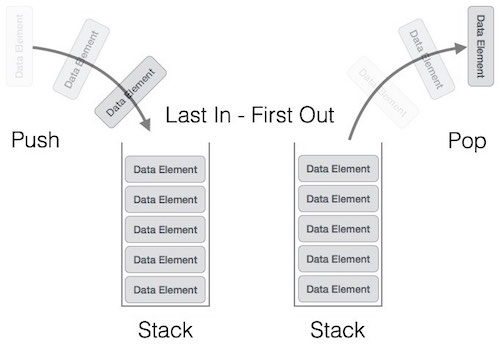

In [ ]:
stack = []
stack.append(8)
stack.append(42)
stack.append(3.141592)
print(stack)

In [ ]:
print(stack.pop())
print(stack.pop())
print(stack.pop())
print(stack.pop())

## Related data structure: The queue

First-in first-out  (versus stack: last-in first-out).


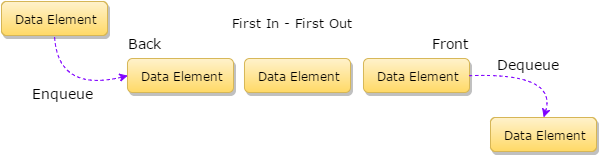

**Python does not have a queue data structure!**

... because it has something better:

## Double-ended queue "deque" (``collections.deque``)

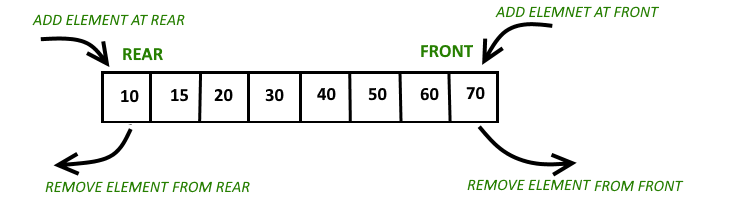

The deque (pronounced "deck" like a deck of cards) is a queue where you can add and remove objects from both ends.

The ``collections.deque`` class is good if you want a:
* Double-ended queue (surprise!)
* Normal (single-ended) queue - just use one end to enqueue, and another to dequeue.
* Stack - use same end to push and pop.  Here ``list`` is an alternative.

But ``list`` can do something ``deque`` cannot (fast access to elements), therefore it exists as a separate class.

# Important libraries for scientific computing and data science

## numpy - Multidimensional arrays for numerical operations

You already know this one.

## scipy - More "fancy" algorithms.


* **Special functions (scipy.special)**  
  Bessel functions,
  Gamma function, spherical harmonics, Legendre functions and many
  many others.
  
* **Integration (scipy.integrate)**  
  Algorithms for numerical
  integration of functions and of ordinary differential equations.

* **Optimization (scipy.optimize)**  
  Minimization of functions in many
  dimensions.  Global optimization.  Root finding.

* **Interpolation (scipy.interpolate)**  
  Interpolation in one or more dimensions.
  
* **Fourier transforms (scipy.fft)**  
  Discrete Fourier Transforms.  
  *For performance critical use, install the FFTW library and the ``PyFFTW`` package.*
  
* **Linear Algrebra (scipy.linalg)**  
  Advanced linear algebra (``numpy`` supports the basic stuff).

* **Spatial data structures and algorithms (scipy.spatial)**  
  Operations on sets of points in $n$-dimensional space. 

and many others ...

### Sister projects: scikit-learn and scikit-image
Algorithms for machine learning and for image manipulation that are too specialized for scipy

### Example: function minimization

Let us define a function of two variables

$f(x, y) = \sin x \cdot \sin y$

It clearly has a minimum where one of the sines is 1 and the other is -1.

In [ ]:
import numpy as np
import scipy.optimize

def f(x):
    return np.sin(x[0]) * np.sin(x[1])

We ask ``scipy.optimize.minimize`` to use the Nelder-Mead simplex algorithm to minimize the function.  We could also have asked for the Powell algorithm, both work well when we do not explictly know the derivatives of the function.

If we know the derivatives of the function, then much faster algorithms are available, such as Broyden-Fletcher-Goldfarb-Shanno algorithm (``method='BFGS'``)

In [ ]:
res = scipy.optimize.minimize(f, (15.0, 15.0), method='nelder-mead',
              options={'xatol': 1e-8, 'disp': True})

In [ ]:
res

In [ ]:
res.x / np.pi

In [ ]:
np.sin(res.x)

### Example: Find neighboring atoms

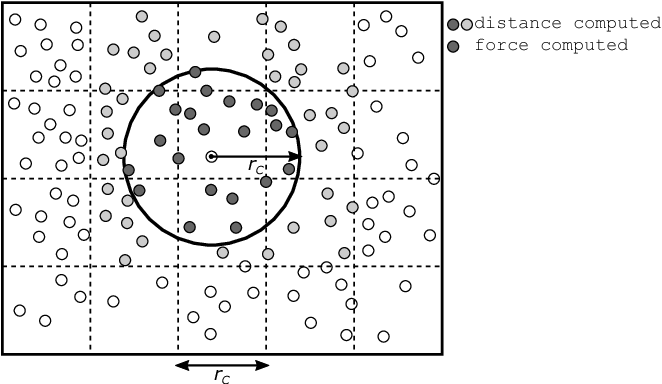

(Source: Ohno *et al.*  DOI: 10.1109/CANDAR.2017.104 )

This task can be formulated as "Given a set of points, which members of the set are close to member number $n$?"

Note that just searching through the set will take time of order $N$ for each lookup, and thus $N^2$ if you need neighbors of all atoms.

This is a special case of "Given a set of points, which members of the set are close the coordinates $\vec r$?"

``scipy.spatial.KDTree`` can solve this problem in the general case.  Creating the data structure takes time of order $N \log N$, searching neighbors for an atom takes $\log N$, the total time is thus $N \log N$.

In [ ]:
N1 = 1e9
N2 = 1e10

print(N2**2 / N1**2)
print(N2 * np.log(N2) / (N1 * np.log(N1)))

## matplotlib - powerful plotting in Python

Matplotlib is the *de facto* standard for plotting in Python.  There are competing packages, and there are packages aiming at "wrapping" matplotlib in simpler interfaces.

Two questions about matplotlib:

* Can matplotlib do XXX?

  Answer: Yes.
  
* How do you get matplotlib to do XXX?

  Answer: Google it!
  
See also the matplotlib Gallery: https://matplotlib.org/gallery/index.html

Note: It starts with the flashy and impressive stuff.  Recently, at lot of simple (and highly useful) examples have been added later in the Gallery.

Like ``numpy``, there is a "canonical" way to import ``matplotlib``.  And Jupyter supports enhanced interfacing with matplotlib enabled with a special command.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

``matplotlib`` is a huge package with a complex
user interface.  Furthermore, the developers decided to make two
different interfaces, one emulating how plotting works in MATLAB, and
one with a more "pythonic" object-oriented interface, and both the
examples in the documentation and the examples you will find on the
internet tend to mix the two in a less-than-elegant melange.

### Example plot
(state-oriented interface a.k.a. MATLAB like interfacde)

In [ ]:
x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

plt.figure()  # Start a new figure
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')

plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('time (s)')
plt.ylabel('Undamped')

# If you are not in a notebook, you need to show the figure with
plt.show()    # Optional in a notebook.

### Identical example plot
(This time with the object-oriented interface)

In [ ]:

x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(x1, y1, 'o-')
ax1.set_title('A tale of 2 subplots')
ax1.set_ylabel('Damped oscillation')

ax2.plot(x2, y2, '.-')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Undamped')

# In addition to showing the figure, we want to save it in a file
fig.savefig("sampleplot.png")

### Example: Plot of 2D data with histograms

Adapted from the Matplotlib Gallery: Scatter plot with histograms.

https://matplotlib.org/gallery/lines_bars_and_markers/scatter_hist.html

In [ ]:
# the random data
x = np.random.randn(1000)
y = np.random.randn(1000)

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(5, 5))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y, c='r', marker='+')

# now determine nice limits by hand:
binwidth = 0.25
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

## pandas - data handling

The ``pandas`` package is intended to make it easier to represent
data for data science and machine learning.  It is mainly focussing on
one- and two-dimensional data sets, where the two-dimensional sets may
be seen as columns of different data kinds.  Pandas support a number
of different data types, including date-time data, and supports that
some data points are missing.  It also supports easy addition of new
data in existing structures.

See also:
* Package overview:  
  https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html

* 10-minute introduction:  
  https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html


Fundamental data objects in pandas:
* The ``Series``: A sequence of data.
* The ``Dataframe``: A table of different kinds of data (series).

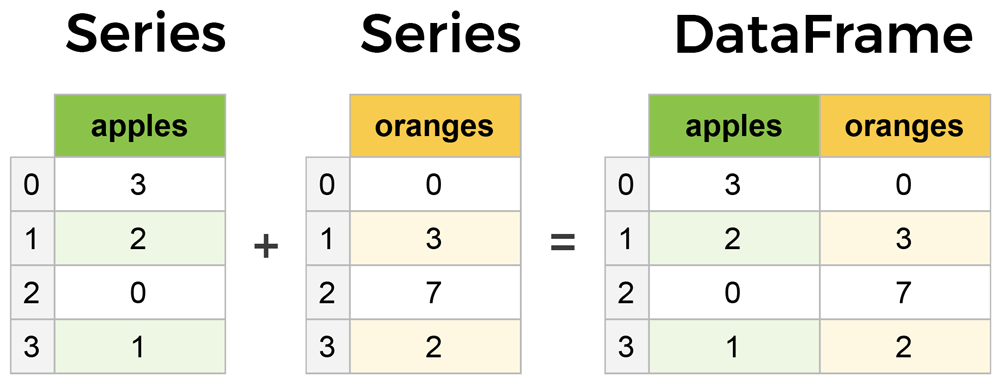
(Source: https://www.learndatasci.com/tutorials/python-pandas-tutorial-complete-introduction-for-beginners/)

In [ ]:
import numpy as np
import pandas as pd

data = {
    'apples': [3, 2, 0, 1], 
    'oranges': [0, 3, 7, 2]
}

purchases = pd.DataFrame(data)

purchases

In [ ]:
print(purchases)

In [ ]:
purchases = pd.DataFrame(data, index=['January', 'February', 'March', 'April'])
purchases

### Example: The Internet Movie Database (IMDB)

<br>
<div>
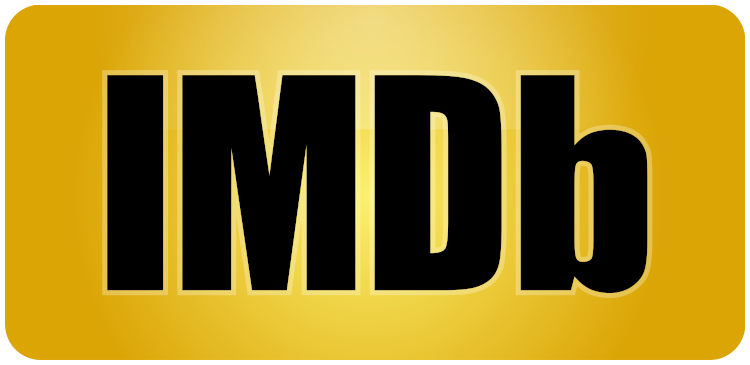
</div><br>

All the data from IMDB can be downloaded online.  It is quite a big data set!

In [ ]:
!ls -lh IMDB

The main database is ``title.basics.tsv.gz``.  The file format is a bit weird, but it is close enough to a CSV (Comma Separated Values) file to be readable by pandas, with a bit of hints.

In [ ]:
movies = pd.read_csv('IMDB/title.basics.tsv.gz', compression='gzip', sep='\t+', 
                     na_values='\\N', engine='python')
movies.head()

What kind of data did we read?

In [ ]:
movies.dtypes

In [ ]:
movies.shape

In [ ]:
movies.sort_values('runtimeMinutes', ascending=False).head(15)

Does this look reasonable?  Halfway down we find "The cure for Insomnia" with a running time of 5220 minutes.

In [ ]:
5220 / 60 / 24

#### From the description on the IMDB web page:

This was the longest movie ever made at a total running time of 87 hours. It premiered in its entirety at The School Of The Art Institute in Chicago, Illinois from 31 January to 3 February 1987 in one continuous showing. Matrjoschka (2006) was released in 2006 with a running time of 95 hours. 

## Exercise

Chose from the following according to taste:

* Finish up your Molecular Dynamics code
* Build an energy minimizer as a "Facade" to scipy's function minimization.  If you do this, talk with Jakob for some hints
* Optional: Play with ``matplotlib``, ``pandas`` or one of the other libraries.